## Machine Learning with Spark - Lab

## Introduction

Previously you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, preparing visualizations, and fitting it in the Spark MLlib framework. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

## The Data

This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex.

You'll use the file `credit_card_default.csv`, which comes from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

## Initial Data Exploration

Get started by writing the relevant import statement and creating a local SparkSession called `spark`, then use that SparkSession to read `credit_card_default.csv` into a Spark SQL DataFrame.

In [1]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession

# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv('./credit_card_default.csv', header='true', inferSchema='true')

Use `.head()` to display the first 5 records, and print out the schema.

In [7]:
# Display the first 5 records
for record in spark_df.head(5):
    print(record)

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)
Row(ID=3, LIMIT_BAL=90000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239.0, BILL_AMT2=14027.0, BILL_AMT3=13559.0, BILL_AMT4=14331.0, BILL_AMT5=14948.0, BILL_AMT6=15549.0, PAY_AMT1=1518.0, PAY_AMT2=1500.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=1000.0, PAY_AMT6=5000.0, default=0)
Row(ID=4, LIMIT_BAL=50000.0, SEX='Female', EDUCATION='College', MARRIAGE='Married', AGE=37, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=46990.0, BILL_AMT2=48233.0, BILL_AMT3=49291.0, BILL_AMT4=28314.0, BILL_AMT5=28959.0, BILL_AMT6=29547.0, PAY_AM

In [8]:
# Print out the schema
spark_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default: integer (nullable = true)



It looks like we have three non-numeric features. For each non-numeric (`string`) feature, select and show all distinct categories.

In [13]:
# Select and show all distinct categories
for col, dtype in spark_df.dtypes:
    if dtype=='string':
        print(spark_df.select(col).distinct().show());

+------+
|   SEX|
+------+
|Female|
|  Male|
+------+

None
+-----------+
|  EDUCATION|
+-----------+
|High School|
|          0|
|          5|
|          6|
|      Other|
|   Graduate|
|    College|
+-----------+

None
+--------+
|MARRIAGE|
+--------+
|       0|
|   Other|
| Married|
|  Single|
+--------+

None


Interesting...it looks like we have some extraneous values in our categories. For example both `EDUCATION` and `MARRIAGE` have a category `0`.

Let's create some visualizations of each of these to determine just how many of them there are.

Create bar plots of the variables `EDUCATION` and `MARRIAGE` to see how the records are distributed between the categories.

<details>
    <summary><u>Click to reveal hint</u></summary>
    
To create a bar plot, you need to group by the category (`.groupBy()`) and then aggregate by the count in that category (`.count()`). That will result in a small DataFrame containing `EDUCATION` and `count` columns.
    
Then the easiest way to create a bar plot is to call `.toPandas()` to make that small Spark SQL DataFrame into a pandas DataFrame, and call `.plot()` on the pandas DataFrame.

</details>

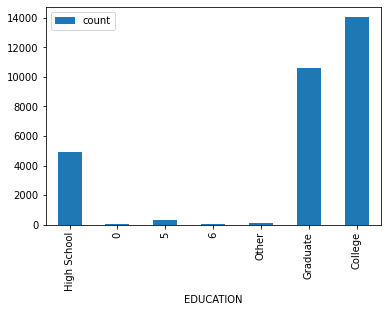

In [18]:
# Create bar plot of EDUCATION
edu = spark_df.groupBy('EDUCATION').count()
edu.toPandas().plot(kind='bar', x='EDUCATION', y='count');

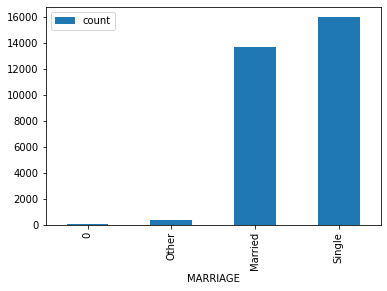

In [19]:
# Create bar plot of MARRIAGE
edu = spark_df.groupBy('MARRIAGE').count()
edu.toPandas().plot(kind='bar', x='MARRIAGE', y='count');

## Binning

It looks like there are barely any records in the `0`, `5`, and `6` categories. Let's go ahead and bin (combine) those with the current `Other` records into a single catch-all `Other` category for both `EDUCATION` and `MARRIAGE`.

The approach we'll use is similar to the `CASE WHEN` technique in SQL. If this were a SQL query, it would look something like this:

```sql
SELECT CASE
       WHEN EDUCATION = '0' THEN 'Other'
       WHEN EDUCATION = '5' THEN 'Other'
       WHEN EDUCATION = '6' THEN 'Other'
       ELSE EDUCATION
       END AS EDUCATION
  FROM credit_card_default;
```

With Spark SQL DataFrames, this is achieved using `.withColumn()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html)) in conjunction with `.when()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.when.html)) and `.otherwise()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.otherwise.html)).

In [25]:
from pyspark.sql import functions as F

# Bin EDUCATION categories
edu_bin = spark_df.withColumn('EDUCATION',
                              F.when(spark_df['EDUCATION']=='0', 'Other')\
                             .when(spark_df['EDUCATION']=='5', 'Other')\
                             .when(spark_df['EDUCATION']=='6', 'Other')\
                             .otherwise(spark_df['EDUCATION']))
# Bin MARRIAGE categories
edu_mar_bin = edu_bin.withColumn('MARRIAGE',
                              F.when(edu_bin['MARRIAGE']=='0', 'Other')\
                             .otherwise(edu_bin['MARRIAGE']))

# Select and show all distinct categories for EDUCATION and MARRIGE again
edu_mar_bin.select('EDUCATION').distinct().show()
edu_mar_bin.select('MARRIAGE').distinct().show()

+-----------+
|  EDUCATION|
+-----------+
|High School|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|   Other|
| Married|
|  Single|
+--------+



Let's also re-create the plots from earlier, now that the data has been binned:

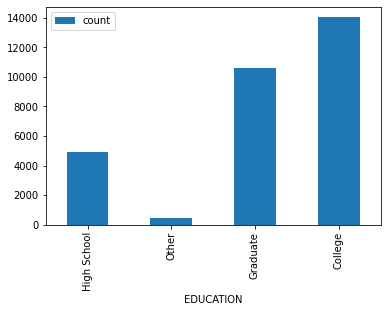

In [26]:
# Plot EDUCATION
edu2 = edu_mar_bin.groupBy('EDUCATION').count()
edu2.toPandas().plot(kind='bar', x='EDUCATION', y='count');

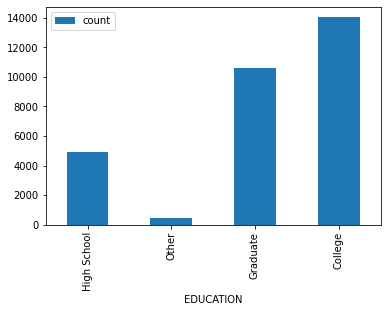

In [27]:
# Plot MARRIAGE
mar2 = edu_mar_bin.groupBy('EDUCATION').count()
mar2.toPandas().plot(kind='bar', x='EDUCATION', y='count');

Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  Class Balance Exploration

Let's first look at the overall distribution of class balance of the `default` column (the target for our upcoming machine learning process). 

Create a bar plot to compare the number of defaults (`0`) vs. non-defaults (`1`). Consider customizing your plot labels as well, since `0` and `1` are not particularly understandable values.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

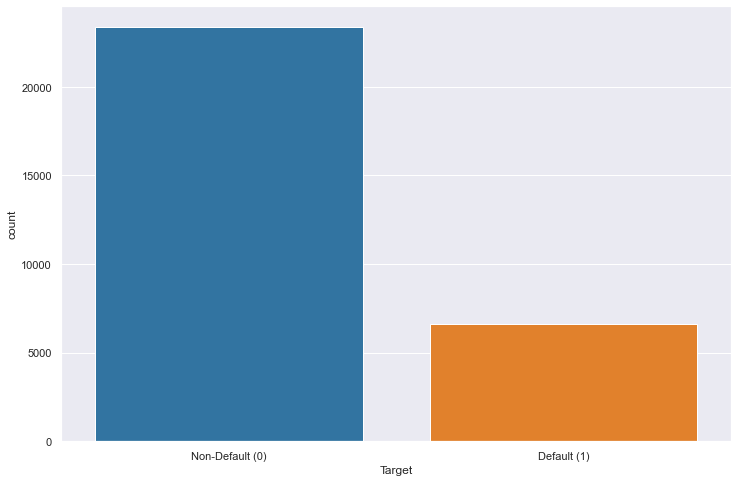

In [33]:
# Group and aggregate target data
group_agg = edu_mar_bin.groupby('default').count().orderBy('default')

# Plot target data
sp_df = group_agg.toPandas()

sns.set_context('notebook')
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=sp_df, x='default',y='count')
ax.set_xlabel("Target")
ax.set_xticklabels(['Non-Default (0)','Default (1)']);

Looks like we have a fairly imbalanced dataset.

Let's also visualize the difference in default rate between males and females in this dataset. Group by both `default` and `SEX` and visualize the comparison.

,default,SEX,count
0,0,Female,14349
1,0,Male,9015
2,1,Female,3762
3,1,Male,2873


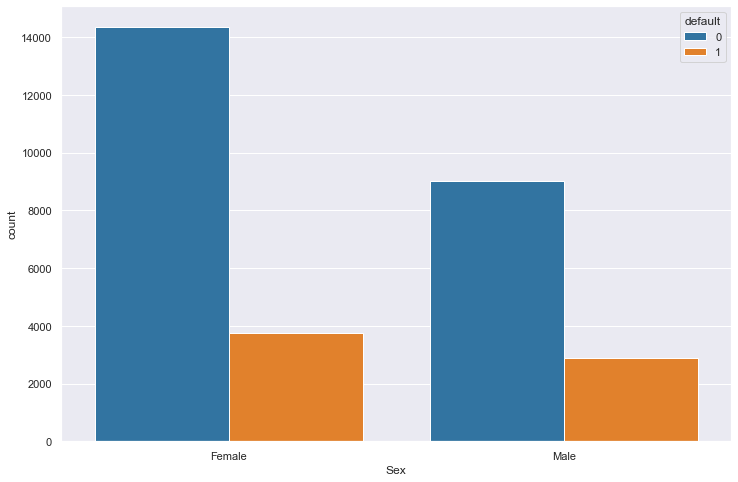

In [52]:
# Group and aggregate target and sex data
sex_group = edu_mar_bin.groupBy(['default', 'SEX']).count().orderBy(['default', 'SEX'])
# Plot target and sex data
sex_df = sex_group.toPandas()
display(sex_df)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=sex_df, x='SEX', hue='default', y='count')
ax.set_xlabel("Sex")
ax.set_xticklabels(['Female','Male']);

It looks like males have an ever so slightly higher default rate than females, and also represent a smaller proportion of the dataset.

## On to the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 `StringIndexer`s
  * One for each categorical feature
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html)
* A `OneHotEncoder`
  * To encode the newly indexed strings into categorical variables
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html)
* A `VectorAssembler`
  * To combine all features into one `SparseVector`
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)

All of these initialized estimators should be stored in a list called `stages`.

In [53]:
# Import the necessary classes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Create the string indexers and determine the names of the numeric
# and indexed columns. Note that ID is an identifier and should NOT
# be included in the numeric columns
ind = []
ind_features = []
num_features = []

for col, dtype in edu_mar_bin.dtypes:
    if dtype == 'string':
        strInd = StringIndexer(inputCol=col, outputCol=col+'_num', handleInvalid='keep')
        ind.append(strInd)
        ind_features.append(strInd.getOutputCol())
    elif col != 'ID' and col != 'default':
        num_features.append(col)

print("Indexed string features:", ind_features)
print("Numeric features:", num_features)

Indexed string features: ['SEX_num', 'EDUCATION_num', 'MARRIAGE_num']
Numeric features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [54]:
# Create a OneHotEncoder to encode the indexed string features
ohe = OneHotEncoder(
    inputCols = ind_features,
    outputCols = [col + '_ohe' for col in ind_features],
    dropLast=True
)

# Determine the names of the final list of features going into the model
features = num_features + ohe.getOutputCols()
print("Final features:", features)

Final features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_num_ohe', 'EDUCATION_num_ohe', 'MARRIAGE_num_ohe']


In [56]:
# Create a VectorAssembler to combine all features
va = VectorAssembler(inputCols=features, outputCol='features')

# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler
stages = ind + [ohe, va]
print("Stages:", stages)

Stages: [StringIndexer_cc1c21125269, StringIndexer_cb7e206e0d1c, StringIndexer_7ad7faac6693, OneHotEncoder_9cbebd4ce419, VectorAssembler_c59fc5f181bb]


Great! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [59]:
# Import relevant class
from pyspark.ml.pipeline import Pipeline

# Instantiate a pipeline using stages list
pipe = Pipeline(stages=stages)

# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column

pipe.fit(edu_mar_bin).transform(edu_mar_bin).head()['features'].size

Exception ignored in: <function JavaWrapper.__del__ at 0x000002AEA4E6FCA0>
Traceback (most recent call last):
  File "C:\Users\willc\Anaconda3\envs\learn-env\lib\site-packages\pyspark\ml\wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


29

<details>
    <summary><u>Click to reveal answer</u></summary>
    
The pipeline should have produced a sparse vector with 29 features.

This comes from:
    
* 20 numeric features
* 3 one-hot encoded features with `dropLast=True`, containing
  * 1 SEX feature
  * 3 EDUCATION features
  * 2 MARRIAGE features

</details>

## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`.

In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default',
    metricName='areaUnderROC'
)

### Logistic Regression

First, we'll try a `LogisticRegression` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)):

* split the data into a train and test set. The basic structure of this is:
```
train, test = df.randomSplit(weights=[0.8, 0.2], seed=1)
```
  * make sure you replace `df` with the actual name of your prepared dataframe
* instantiate a logistic regression with `standardization=True` and add it to the stages list
* instantiate a new Pipeline estimator with all of the stages
* fit the pipeline on the training data
* transform both train and test data using the pipeline
* use `evaluator` to evaluate performance on train vs. test

In [61]:
from pyspark.ml.classification import LogisticRegression

# Your code here
train, test = edu_mar_bin.randomSplit(weights=[0.8, 0.2], seed=1)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='default',
    predictionCol='prediction',
    standardization=True
)

lr_stages = stages + [lr]

lr_pipe = Pipeline(stages=lr_stages)

lr_pipe_fit = lr_pipe.fit(train)

lr_train = lr_pipe_fit.transform(train)
lr_test = lr_pipe_fit.transform(test)

print("Train set ROC/AUC:", evaluator.evaluate(lr_train))
print("Test set ROC/AUC:", evaluator.evaluate(lr_test))

Train set ROC/AUC: 0.6057796783170918
Test set ROC/AUC: 0.6090136625813551


Looks like the defaults for `LogisticRegression` are working pretty well, since the train and test metrics are pretty similar.

Still, let's try a `CrossValidator` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)) + `ParamGridBuilder` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) approach with a few different regularization parameters.

We'll use these regularization parameters:

```python
[0.0, 0.01, 0.1, 1.0]
```

In the cell below:

* instantiate a `ParamGridBuilder` that tests out the `regParam` values listed above
* instantiate a `CrossValidator` that uses the param grid you just created as well as `evaluator` and the pipeline you created earlier
* fit the `CrossValidator` on the full DataFrame
* display the metrics for all models, and identify the best model parameters

In [63]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr_pg = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0]).build()

lr_cv = CrossValidator(
    estimator=lr_pipe,
    estimatorParamMaps=lr_pg,
    evaluator=evaluator
)

lr_model = lr_cv.fit(edu_mar_bin)

lr_model.avgMetrics

[0.6080831992549425,
 0.5974610320317754,
 0.5582061652985906,
 0.5048196653475087]

Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. You can find all of the available classification model options [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated classifier as well as print out the AUC of the best-performing model and the best parameters.

In [67]:
final_df = edu_mar_bin

In [64]:
from pyspark.ml.classification import\
    RandomForestClassifier, DecisionTreeClassifier,\
    GBTClassifier, FMClassifier, MultilayerPerceptronClassifier

In [83]:
import numpy as np

In [84]:
# Create a function to cross validate different classifiers with different parameters
def cv_model(df, stages, clf, param_grid, evaluator):
    stages_with_clf = stages + [clf]
    pipe = Pipeline(stages=stages_with_clf)
    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=param_grid,
        evaluator=evaluator
    )
    model = cv.fit(df)
    
    best_clf_ind = np.argmax(model.avgMetrics)
    best_clf_metric = model.avgMetrics[best_clf_ind]
    best_clf_params = param_grid[best_clf_ind]
    
    print(f"Best {evaluator.getMetricName()}: {best_clf_metric}")
    print(f"Best params: {best_clf_params}")
    
    return model

Now train one other classifier that is not a `LogisticRegression`. Use a `ParamGridBuilder` to try out some relevant parameters.

And one more:

In [85]:
# Your code here
# ⏰ This cell may take a long time to run
rf = RandomForestClassifier(featuresCol='features',labelCol='default')
rf_params = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [4,8])\
    .addGrid(rf.numTrees, [10,50])\
    .build()

rf_model = cv_model(final_df, stages, rf, rf_params, evaluator)

Best areaUnderROC: 0.6547091713860016
Best params: {Param(parent='RandomForestClassifier_a206cb80305f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8, Param(parent='RandomForestClassifier_a206cb80305f', name='numTrees', doc='Number of trees to train (>= 1).'): 10}


In [88]:
dt = DecisionTreeClassifier(featuresCol='features',labelCol='default')
dt_params = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 10, 15])\
    .build()

dt_model = cv_model(final_df, stages, dt, dt_params, evaluator)

Best areaUnderROC: 0.6530402333719036
Best params: {Param(parent='DecisionTreeClassifier_a165a392f144', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}


In [90]:
gbt = GBTClassifier(featuresCol='features',labelCol='default')
gbt_params = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2,8])\
    .addGrid(gbt.maxIter,[25,75])\
    .build()

gbt_model = cv_model(final_df, stages, gbt, gbt_params, evaluator)

Best areaUnderROC: 0.6567210743031695
Best params: {Param(parent='GBTClassifier_4a549235546b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_4a549235546b', name='maxIter', doc='max number of iterations (>= 0).'): 75}


In [92]:
fm = FMClassifier(featuresCol='features',labelCol='default')
fm_params = ParamGridBuilder()\
    .addGrid(fm.solver, ['gd', 'adamW'])\
    .addGrid(fm.maxIter,[10,50])\
    .build()

fm_model = cv_model(final_df, stages, fm, fm_params, evaluator)

Best areaUnderROC: 0.5313348364712092
Best params: {Param(parent='FMClassifier_ca0960fff158', name='solver', doc='The solver algorithm for optimization. Supported options: gd, adamW. (Default adamW)'): 'adamW', Param(parent='FMClassifier_ca0960fff158', name='maxIter', doc='max number of iterations (>= 0).'): 10}


Which classifier turned out to be the best overall?

In [93]:
# Your answer here
"""

""";

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

In [116]:
mlp = MultilayerPerceptronClassifier(
    featuresCol='features',
    labelCol='default',layers=[29,1,2],
    maxIter=20
)
mlp_params = ParamGridBuilder()\
    .addGrid(mlp.solver,['l-bfgs', 'gd'])\
    .addGrid(mlp.stepSize,[0.0001,0.05])\
    .build()

mlp_model = cv_model(final_df, stages, mlp, mlp_params, evaluator)

Best areaUnderROC: 0.5
Best params: {Param(parent='MultilayerPerceptronClassifier_7ae41b7d5cc2', name='solver', doc='The solver algorithm for optimization. Supported options: l-bfgs, gd.'): 'l-bfgs', Param(parent='MultilayerPerceptronClassifier_7ae41b7d5cc2', name='stepSize', doc='Step size to be used for each iteration of optimization (>= 0).'): 0.0001}


## Stop the Spark Session

In [117]:
spark.stop()

## Summary

If you've made it this far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.